# Diagnosis of a bad Digits classification

Make a Naive Bayes classifier for the Digits task, this uses an 8x8 greyscale of the digits 0-9, the task is to predict the correct label from the image.

This Notebook is a part of my [Data Science Delivered](https://github.com/ianozsvald/data_science_delivered) notes. License: CC-By-Attribution.

Generally we do pretty well even just with Naive Bayes. Below we use a Confusion Matrix to identify the classes that are hard to predict (1s get mis-classified a portion of the time). Next we'll pull out an example that's misclassified.

A simple debugging process would be:

* run a classifier using 10-fold cross validation, note the results
* use a Confusion Matrix to identify areas needing improvement
* investigate the highest-probability wrong answers
* ponder on why the classifier is making these mistakes
 * consider adding new features or cleaning your data or trying a new classifier or tuning your hyperparameters
* repeat

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.dummy import DummyClassifier
from sklearn import cross_validation
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

from sklearn import naive_bayes

# let's plot inline
%matplotlib inline

# load the digits dataset
from sklearn.datasets import load_digits
digits = load_digits()

/home/ian/anaconda/envs/scratch/lib/python3.4/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
# install watermark using
# %install_ext https://raw.githubusercontent.com/rasbt/watermark/master/watermark.py
%load_ext watermark
# show a watermark for this environment
%watermark -d -m -v -p numpy,matplotlib -g

2016-01-31 

CPython 3.4.4
IPython 4.0.1

numpy 1.10.2
matplotlib 1.5.0

compiler   : GCC 4.4.7 20120313 (Red Hat 4.4.7-1)
system     : Linux
release    : 3.16.0-38-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 8
interpreter: 64bit
Git hash   : bd6a7a30199b5d52248b26ad0b6898a63b44a56a


In [3]:
# start a separate QTconsole for interactive coding
#%qtconsole

In [4]:
# flatten and binarise the 2D input image - this is our basic feature set
# we could improve the features here by adding new columns to X
arr_digits_greyscale = [digit.flatten() for digit in digits.images]
arr_digits = [digit.flatten()>=8 for digit in digits.images]
X_greyscale = np.vstack(arr_digits_greyscale)
X = np.vstack(arr_digits)
y = digits.target
print("X has shape {}, y has shape {}".format(X.shape, y.shape))

X has shape (1797, 64), y has shape (1797,)


# Visualise some of our examples

y (target label) =  0
Image for X[0] = 


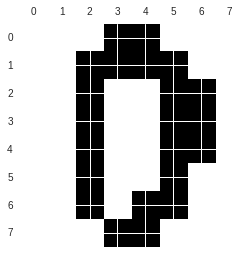

In [5]:
def show_example(idx, X, y):
    """Show an example as an image from X"""
    print("y (target label) = ", y[idx])
    print("Image for X[{}] = ".format(idx))
    plt.matshow(X[idx].reshape((8,8)))
    
show_example(0, X, y)

y (target label) =  1
Image for X[11] = 


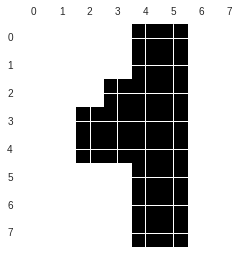

In [6]:
show_example(11, X, y)

# Make a DummyClassifier

The goal here is to make a basic no-intelligence classifier, anything we do after this point must show an improvement or else we're not learning anything! This classifier makes a classificiation based on the *dominant class* in the training set (for each fold).

In [7]:
clf = DummyClassifier()
cv = cross_validation.StratifiedKFold(y=y, n_folds=10, shuffle=True)

scores = cross_validation.cross_val_score(clf, X, y, cv=cv)

"Scores: {:0.3f} +/- {:0.3f} (2 s.d.)".format(scores.mean(), scores.std()*2)
# We expect a 10% score if we're guessing the majority class for a 
# 10 class problem when we have an example number of examples per class

'Scores: 0.097 +/- 0.055 (2 s.d.)'

# Bernoulli NaiveBayes

Now we'll make a proper (if simple) classifier and confirm that it outperforms the DummyClassifier

In [8]:
clf = naive_bayes.BernoulliNB()
# you'll improve things by trying a new classifier here

cv = cross_validation.StratifiedKFold(y=y, n_folds=10, shuffle=True)

scores = cross_validation.cross_val_score(clf, X, y, cv=cv)

"Scores: {:0.3f} +/- {:0.3f} (2 s.d.)".format(scores.mean(), scores.std()*2)
# We expect approximately 88% accuracy

'Scores: 0.891 +/- 0.037 (2 s.d.)'

# Next we'll Train on 66% of the Data and Test on 33%

In [9]:
# We'll fix a random seed so the results are the same on each run,
# you wouldn't do this in practice but it does help when you're debugging
random_state = 47
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
_, X_test_greyscale, _, _ = train_test_split(X_greyscale, y, test_size=test_size, random_state=random_state)

print("Score on the training data:")
clf.fit(X_train, y_train)
print(clf.score(X_train, y_train))

print("Score on the test split:")
print(clf.score(X_test, y_test))
# We expect both train and test scores to be pretty similar

Score on the training data:
0.901080631754
Score on the test split:
0.897306397306


# Use Precision and Recall to Identify Badly Performing Classes

```
"The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.

"The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples."
```
http://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html

```
... precision (also called positive predictive value) is the fraction of retrieved instances that are relevant, while recall (also known as sensitivity) is the fraction of relevant instances that are retrieved.
```
https://en.wikipedia.org/wiki/Precision_and_recall

Class 1's Precision is worst (Class 0 is the best), we should probably fix this first. It predicts a 1 for most of class 1 items, but it also mis-classifies other examples as class 1 (oftens class 8s).

Class 8 has the worst Recall. When the classifier predicts an 8 it is generally right, but often true 8s get classified as other classes.

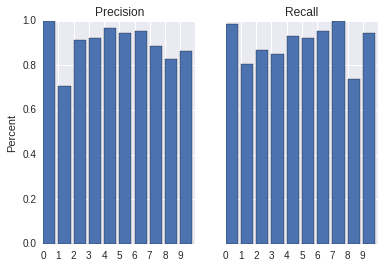

In [10]:
predicted_y_test = clf.predict(X_test)
precision, recall, fbeta_score, support = precision_recall_fscore_support(y_test, predicted_y_test)

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)  #, fig_kw = {"figsize":(6,4)})
#ax1.plot(x, y)
ax1.set_title('Precision')
ax1.set_ylabel("Percent")
ax2.set_title('Recall')

# plot bars, set 10 class labels
classes = np.arange(precision.shape[0])
_ = ax1.bar(classes, precision)
ax1.set_xticklabels([str(c) for c in classes])
_ = ax1.set_xticks(classes)
_ = ax2.bar(classes, recall)
ax2.set_xticklabels([str(c) for c in classes])
_ = ax2.set_xticks(classes)

# Plot Confusion Matrix to Visualise Incorrect Classifications

We see that the diagonal is pretty good (each class is often correctly predicted). Class 1 is sometimes mis-predicted, let's diagnose this.

For random_seed=47 we see that Class 1 is often mislabelled (for 8s and 2s), also Class 8 is mislabelled for Class 1s.

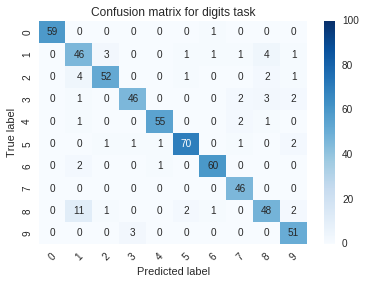

In [11]:
def plot_confusion_matrix(df, cmap=plt.cm.Blues, title="Confusion matrix"):
    """Use Seaborn to plot the confusion matrix"""
    sns.heatmap(df, annot=True, vmin=0, vmax=100, cmap=cmap)
    plt.ylabel('True label')
    plt.yticks(rotation=90)
    plt.xlabel('Predicted label')
    plt.xticks(rotation=45)
    plt.title(title)
    
cm = confusion_matrix(y_test, clf.predict(X_test))

col_names = [str(n) for n in range(10)]
cm_df = pd.DataFrame(data=cm, columns=col_names, index=col_names)
plot_confusion_matrix(cm_df, title="Confusion matrix for digits task")

## Show probabilities for each example of this class

In [12]:
# Get the indices for class 1 for our diagnosis
target_class = 1 # class we want to investigate
true_labels_1s_indices = y_test == target_class
predictions_with_1s_as_truth = clf.predict(X_test)[true_labels_1s_indices]
# Get the class predictions for every example of Class 1
predictions_probabilities_with_1s_as_truth = clf.predict_proba(X_test)[true_labels_1s_indices]

## We hope each Class 1 example to be labelled a 1

Each mis-prediction means that another class had a higher probability of being chosen than Class 1, for this Class 1 example. We'll draw a matrix of examples (rows) and the 10 class probabilities to see which ones are more likely to be chosen for a set of Class 1 examples.

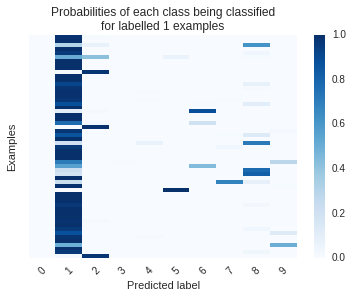

In [13]:
# Convert the 2D array of probabilities into a dictionary of column vectors    
cols_to_vectors_dict = {c:predictions_probabilities_with_1s_as_truth[:,c] for c in range(predictions_probabilities_with_1s_as_truth.shape[1])}
df_cols_to_vectors = pd.DataFrame(cols_to_vectors_dict)
    
def plot_classification_probabilities(df, title, cmap=plt.cm.Blues):
    """Plot 10 columns of class probabilities for all the examples in our dataframe"""
    sns.heatmap(df, annot=False, vmin=0, vmax=1, cmap=cmap, yticklabels=False)
    plt.ylabel('Examples')
    #plt.yticks(rotation=90)
    plt.xlabel('Predicted label')
    plt.xticks(rotation=45)
    plt.title(title)
plot_classification_probabilities(df_cols_to_vectors, title="Probabilities of each class being classified\nfor labelled {} examples".format(target_class))

In [14]:
# use argsort to return an array of indices where the 0th item (index_to_investigate) represents the 
# index of the lowest item in predictions_probabilities_with_1s_as_truth (and the 1st item 
# is the next-lowest etc) and select the index of the least-confident prediction of class 1
index_to_investigate = 0  # you can ask for 0 to 9th least-confident (where 9==most confident) item
idx_least_confident_prediction_for_class_1 = predictions_probabilities_with_1s_as_truth[:,target_class].argsort()[index_to_investigate]
print("Index-{} least confident Class {} prediction is on row {} of predictions_with_1s_as_truth".format(index_to_investigate, target_class, idx_least_confident_prediction_for_class_1))

Index-0 least confident Class 1 prediction is on row 39 of predictions_with_1s_as_truth


Probabilities:
 [  6.27088451e-07   3.96269005e-04   8.70094092e-06   4.94674663e-10
   6.77184449e-05   9.98399714e-01   1.11846526e-04   2.25250852e-07
   1.01389939e-03   9.99006775e-07]


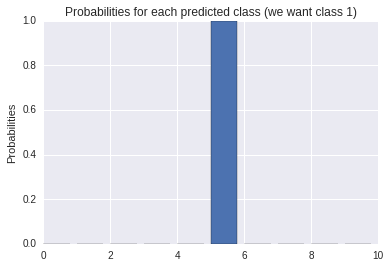

In [15]:
# for this one example we can get all 10 class probabilities
probabilities_per_class = predictions_probabilities_with_1s_as_truth[idx_least_confident_prediction_for_class_1]
print("Probabilities:\n", probabilities_per_class)
_ = plt.bar(np.arange(probabilities_per_class.shape[0]), probabilities_per_class)
plt.ylabel("Probabilities")
plt.title("Probabilities for each predicted class (we want class {})".format(target_class))

In [16]:
# the *most* confident class has the highest probability
idx_most_confident_class_for_this_example = probabilities_per_class.argsort()[-1]
print("We'd *incorrectly* predicted class {} for this example with probability {}".format(idx_most_confident_class_for_this_example, probabilities_per_class[idx_most_confident_class_for_this_example]))

We'd *incorrectly* predicted class 5 for this example with probability 0.9983997138505155


# Show image for this mis-predicted example

We can show the image and class (1) for this example, the cell above shows the mis-predicted label.

y (target label) =  1
Image for X[420] = 


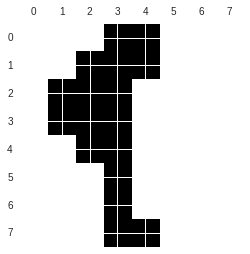

In [17]:
idx_for_truth_for_this_example = np.arange(true_labels_1s_indices.shape[0])[true_labels_1s_indices][idx_least_confident_prediction_for_class_1]
show_example(idx_for_truth_for_this_example, X_test, y_test)

y (target label) =  1
Image for X[420] = 


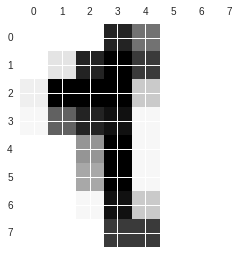

In [18]:
show_example(idx_for_truth_for_this_example, X_test_greyscale, y_test)

# Next steps

* Now we can see which image is mis-classified, you should look at lots more examples
* Understand why the misclassification might occur
* Might other features help?
* Might our greyscale cut-off process be sub-optimal?